In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it
from sklearn.preprocessing import StandardScaler
import warnings

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from pyearth import Earth

In [2]:
warnings.filterwarnings("ignore")

In [11]:
train = pd.read_csv('data/train.csv')
train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5


In [12]:
test = pd.read_csv('data/test.csv')
test.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,5380,6.507826e+10,7882.15,6.82,0.00210,1.712586e+09,0.39,583617.74,862986.0,63872.0,...,0.0380,0.0010,90204869909,0.26,8.0,5,5.0,30.1213,27.95,-0.49
1,5381,3.122741e+09,4682.13,8.17,0.00010,1.040914e+09,0.00,190000.65,688710.0,35407.0,...,0.1866,0.0192,37449565014,0.02,16.0,1,8.0,2.1282,10.18,0.55
2,5382,3.888719e+10,7495.57,7.15,0.00285,2.160400e+09,0.42,351570.67,841523.0,170240.0,...,0.0100,0.0017,10847937619,0.83,35.0,1,19.0,7.8513,21.27,19.09
3,5383,7.727427e+10,4003.76,6.53,0.00165,5.519591e+09,0.00,320216.05,466131.0,35.0,...,0.4636,0.0000,37200096,0.51,1.0,4,0.0,9.0511,18.38,4.11
4,5384,4.184868e+09,34874.72,6.39,0.00065,1.046217e+09,0.50,3349978.53,3711028.0,1757.0,...,2.8737,0.0001,16400000000000,0.12,2.0,1,2.0,2.6512,149.68,0.02


In [13]:
train = train.fillna(0)
y_train = train['y']
X_train = train.drop(['y', 'id'], axis = 1)

## PCA

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [15]:
pca = PCA(0.65)
pca.fit(X_train)

PCA(n_components=0.65)

In [16]:
X_train = pca.transform(X_train)
X_train.shape

(5380, 14)

In [17]:
X_test = test
col_id = test['id']
X_test = test.drop(['id'], axis = 1)
X_test = X_test.fillna(0)
X_test = scaler.transform(X_test)

In [18]:
X_test = pca.transform(X_test)
X_test.shape

(4403, 14)

## AdaBoost

>2 11.575 (0.663)
>3 11.816 (0.298)
>4 11.754 (0.400)
>5 11.769 (0.262)
>6 11.739 (0.147)
>7 12.064 (0.376)
>8 12.104 (0.294)
>9 12.306 (0.362)
>10 12.365 (0.305)


Text(0.5, 0, 'Number of trees')

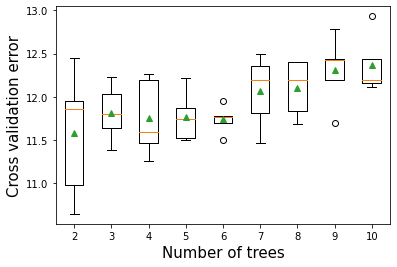

In [19]:
def get_models():
    models = dict()
    n_trees = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    for n in n_trees:
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 12.583 (1.096)
>2 12.776 (1.182)
>3 13.458 (0.913)
>4 14.935 (1.198)
>5 13.460 (0.916)
>6 12.205 (0.954)
>7 11.382 (1.145)
>8 10.865 (1.327)
>9 10.654 (1.424)
>10 10.572 (1.453)
>11 10.507 (1.385)
>12 10.601 (1.484)
>13 10.590 (1.430)
>14 10.608 (1.475)
>15 10.641 (1.419)


Text(0.5, 0, 'Depth of each tree')

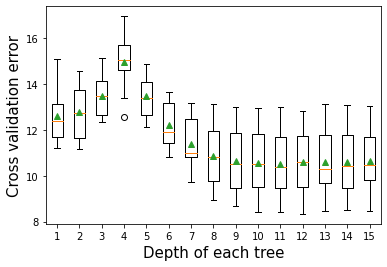

In [20]:
def get_models():
    models = dict()
    for i in range(1,16):
        base = DecisionTreeRegressor(max_depth=i)
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
# plot    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

In [22]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [3, 4, 5]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=5), DecisionTreeRegressor(max_depth=6)]

cv = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: -128.926685 using {'base_estimator': DecisionTreeRegressor(max_depth=5), 'n_estimators': 4}


In [23]:
model_ADA = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5), n_estimators=4,
                              random_state=1).fit(X_train, y_train)

## RF

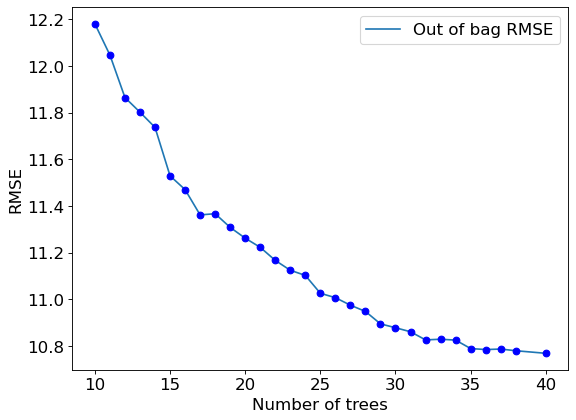

In [30]:
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}
for i in np.linspace(10, 40, 30,dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1,max_features="sqrt",
                        n_jobs=-1,oob_score=True).fit(X_train, y_train)
    oob_rsquared[i]=model.oob_score_  
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y_train))
    
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

Text(0, 0.5, 'Classification accuracy')

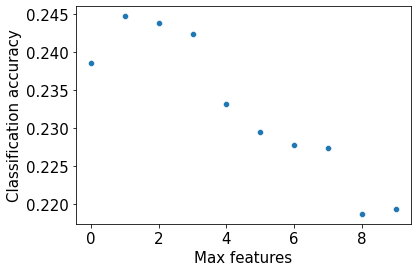

In [31]:
oob_score = {}

i=0
for pr in range(1, 11):
    model = RandomForestRegressor(random_state=1, oob_score=True, verbose=False, n_estimators = 500,
                                  max_features=pr, n_jobs=-1).fit(X_train, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
sns.scatterplot(x = oob_score.keys(), y = oob_score.values())
plt.xlabel('Max features')
plt.ylabel('Classification accuracy')

In [32]:
params = {'n_estimators': [12, 15],
          'max_features': [4, 6, 8]}
param_list=list(it.product(*(params[Name] for Name in params)))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_features=pr[1],n_jobs=-1).fit(X_train, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (15, 8)
Best score (R-squared) =  0.08128852809558373


In [33]:
model_RF = RandomForestRegressor(n_estimators=15, max_features=8, random_state=1, n_jobs=-1).fit(X_train, y_train)

## XGBoost

>3 11.371 (0.766)
>4 11.139 (0.709)
>5 11.020 (0.705)
>6 10.970 (0.694)
>7 10.903 (0.639)
>8 10.920 (0.608)
>9 10.905 (0.581)


Text(0.5, 0, 'Number of trees')

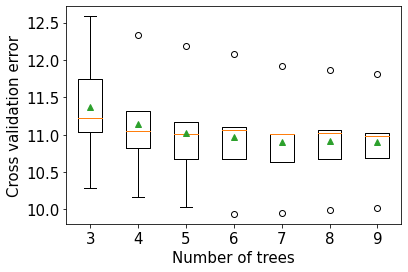

In [34]:
def get_models():
    models = dict()
    n_trees = [3, 4, 5, 6, 7, 8, 9]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 10.481 (1.364)
>3 10.537 (1.370)
>5 10.971 (1.098)
>7 11.142 (1.254)
>9 11.281 (1.312)
>11 11.513 (1.190)
>13 11.538 (1.120)


Text(0.5, 0, 'Depth of each tree')

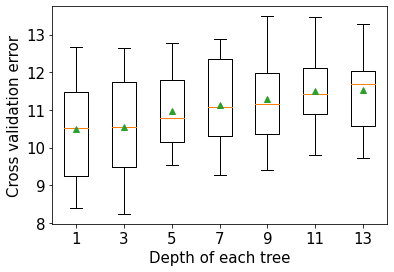

In [35]:
def get_models():
    models = dict()
    for i in range(1,15,2):
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0100 11.2 (1.6)
>0.0150 10.8 (1.5)
>0.0200 10.7 (1.4)
>0.0250 10.6 (1.4)
>0.0300 10.6 (1.4)


Text(0.5, 0, 'Learning rate')

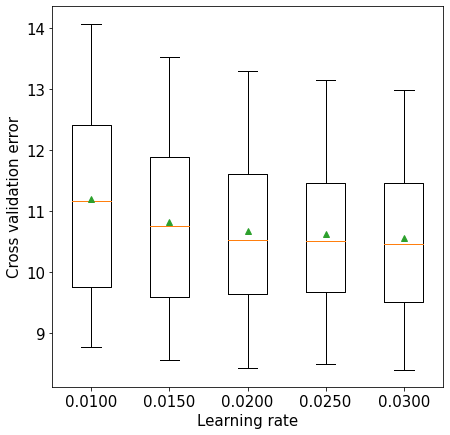

In [36]:
def get_models():
    models = dict()
    for i in [0.010, 0.015, 0.020, 0.025, 0.030]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
    
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.1000 11.4 (1.1)
>0.5000 11.1 (1.3)
>1.0000 11.0 (1.2)


Text(0.5, 0, 'reg_lambda')

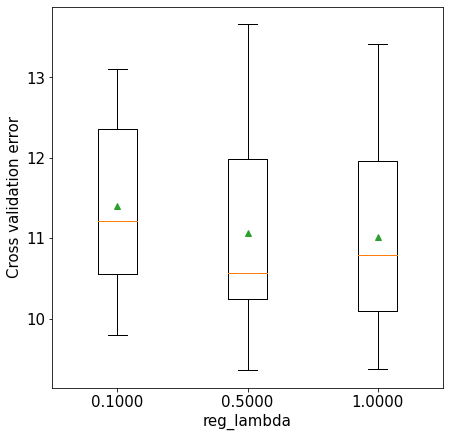

In [38]:
def get_models():
    models = dict()
    for i in [0.1, 0.5, 1]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))

plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

In [ ]:
param_grid = {'n_estimators':[4, 5, 6],
              'max_depth': [2, 3, 4],
              'learning_rate': [0.10, 0.125, 0.15],
              'reg_lambda':[0.1, 0.2, 0.3, 0.4, 0.5]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train , y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


In [37]:
model_XG = xgb.XGBRegressor(random_state=1, n_estimators=6, max_depth=4, learning_rate = 0.15, reg_lambda=1).fit(X_train, y_train)

## Ensemble

In [38]:
model_ensemble= StackingRegressor(estimators = [('ADA', model_ADA),
                                                ('RF', model_RF),
                                                ('XG', model_XG)],
                      final_estimator = LassoCV(),
                      cv = KFold(n_splits = 5, shuffle = True, random_state=1))
model_ensemble.fit(X_train, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                  estimators=[('ADA',
                               AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                                                 n_estimators=4,
                                                 random_state=1)),
                              ('RF',
                               RandomForestRegressor(max_features=4,
                                                     n_estimators=21, n_jobs=-1,
                                                     random_state=1)),
                              ('XG',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_by...
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constrain

In [39]:
model_ensemble.final_estimator_.coef_

array([0.1546217 , 0.60771368, 0.77878442])

In [40]:
pred8 = model_ensemble.predict(X_test)

pred_v8 = pd.DataFrame(index=range(X_test.shape[0]), columns=range(2))
pred_v8.columns = ['id', 'y']
pred_v8['id'] = col_id
pred_v8['y'] = pred8
pred_v8

,id,y
0,5380,5.763841
1,5381,10.446624
2,5382,4.699714
3,5383,3.513225
4,5384,9.313334
...,...,...
4398,9778,3.612204
4399,9779,9.977409
4400,9780,6.159185
4401,9781,10.422466


In [41]:
pred_v8.to_csv('pred_v8.csv', index=True)